In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
import tensorflow as tf

from tqdm import tqdm
from numba import njit

from msfm.utils.io import read_yaml

In this notebook, different ways to calculate the underlying number of galaxies per pixel for the Metacalibration sample are compared. 

### global constants

In [44]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

l_max = 2*n_side

# Metacal tomo bin
metacal_tomo = 1

### functions

In [45]:
def plot_patch(patch, title=""):
    patch_plot = patch.copy()
    patch_plot[patch == 0] = hp.UNSEEN

    hp.mollview(patch_plot, title=title)
    hp.graticule()

    hp.gnomview(patch_plot, title=title)

    print(f"n_gal = {np.sum(patch):.4e}")

# Catalog

### load the Metacalibration catalog

In [46]:
# Metacalibration sample
metacal_dir = '/Users/arne/data/DESY3/DES_Y3KP_NGSF/'

# ellipticities for a fixed tomographic bin
g1 = h5py.File(os.path.join(metacal_dir, f'cal_e1_tomo={metacal_tomo}.h5'))['cal_e1'][:]
g2 = h5py.File(os.path.join(metacal_dir, f'cal_e2_tomo={metacal_tomo}.h5'))['cal_e2'][:]
w = h5py.File(os.path.join(metacal_dir, f'weight_tomo={metacal_tomo}.h5'))['weight'][:]

# J2000 angles in degrees
alpha_metacal = h5py.File(os.path.join(metacal_dir, f'ALPHAWIN_J2000_tomo={metacal_tomo}.h5'))['ALPHAWIN_J2000'][:]
delta_metacal = h5py.File(os.path.join(metacal_dir, f'DELTAWIN_J2000_tomo={metacal_tomo}.h5'))['DELTAWIN_J2000'][:]

assert g1.shape == g2.shape == alpha_metacal.shape == delta_metacal.shape

# angles like in healpy in radian
theta = -np.deg2rad(delta_metacal) + np.pi/2
phi = np.deg2rad(alpha_metacal)

# galaxy level: derived pixel ids, shape (num_galaxies,)
metacal_ids = hp.ang2pix(nside=n_side, theta=theta, phi=phi)

# pixel level: derived pixel ids and number of galaxies per pixel
metacal_patch_pix, metacal_n_gal = np.unique(metacal_ids, return_counts=True)

# mean number of galaxies per pixel
n_bar = len(g1)/len(metacal_patch_pix)
print(f"n_bar = {n_bar} [galaxies/pixel]")

# number of galaxies per pixel
metacal_counts = np.zeros(n_pix)
metacal_counts[metacal_patch_pix] = metacal_n_gal

n_bar = 67.34968796666604 [galaxies/pixel]


n_gal = 2.4940e+07


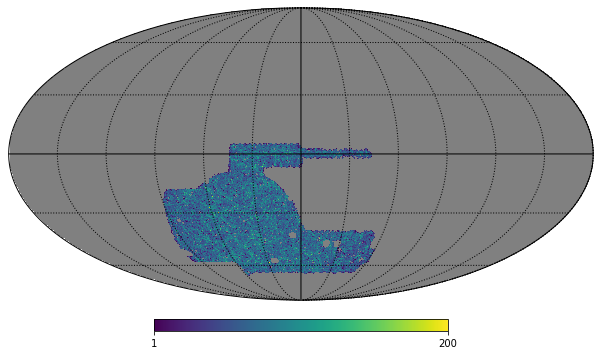

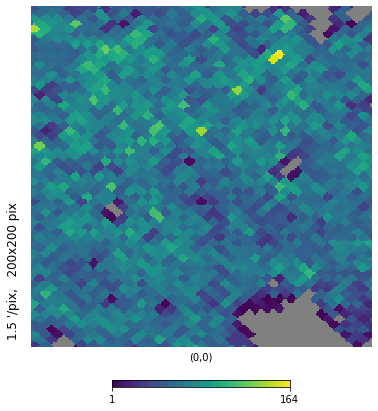

In [47]:
plot_patch(metacal_counts)

# N-body

In [48]:
patch_pix = metacal_patch_pix
anti_patch_pix = np.setdiff1d(np.arange(n_pix), patch_pix)

### load a Metacalibration like simulated delta map

In [78]:
# according to Marco this should be alright
metacal_bias = 1

In [79]:
# load fiducial cosmology
projected_maps_dir = "/Users/arne/data/CosmoGrid_example/DES/Fiducial/perm_0000/projected_probes_maps_nobaryons512.h5"
with h5py.File(projected_maps_dir, "r") as f:
    dg_map = f[f"dg/desy3metacal{metacal_tomo}"][:]

# normalize the number density contrast
dg_map = (dg_map - np.mean(dg_map))/np.mean(dg_map)

# number of galaxies per pixel
sim_counts = (1+metacal_bias*dg_map)*n_bar
noisy_sim_counts = np.random.poisson(sim_counts)
noisy_sim_counts = noisy_sim_counts.astype(np.float32)

# apply masking
sim_counts[anti_patch_pix] = 0
noisy_sim_counts[anti_patch_pix] = 0

n_gal = 2.4863e+07


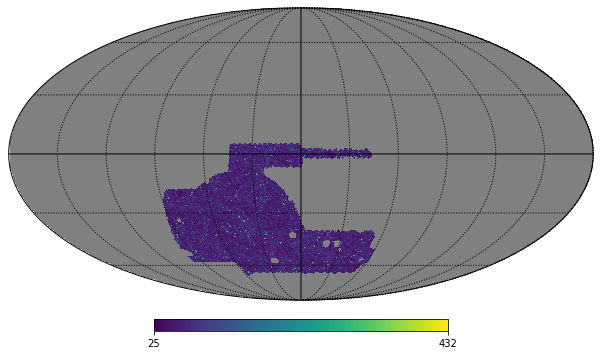

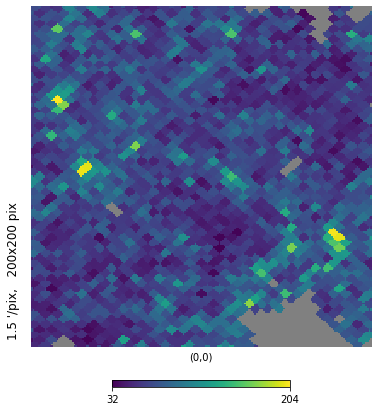

In [80]:
plot_patch(noisy_sim_counts)

# Comparison

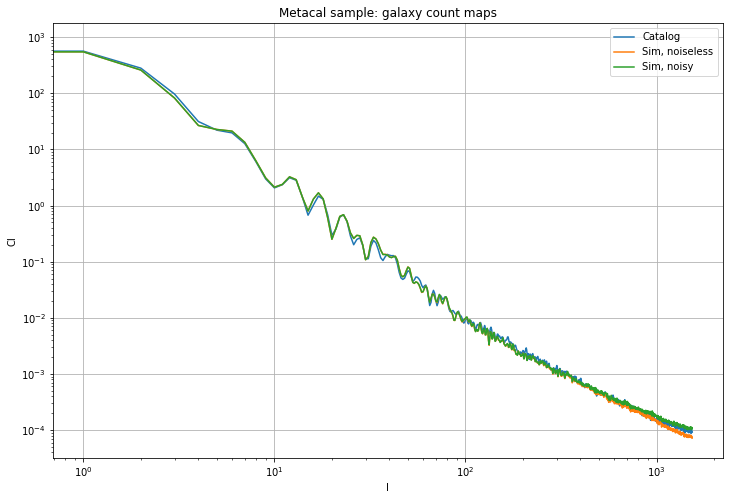

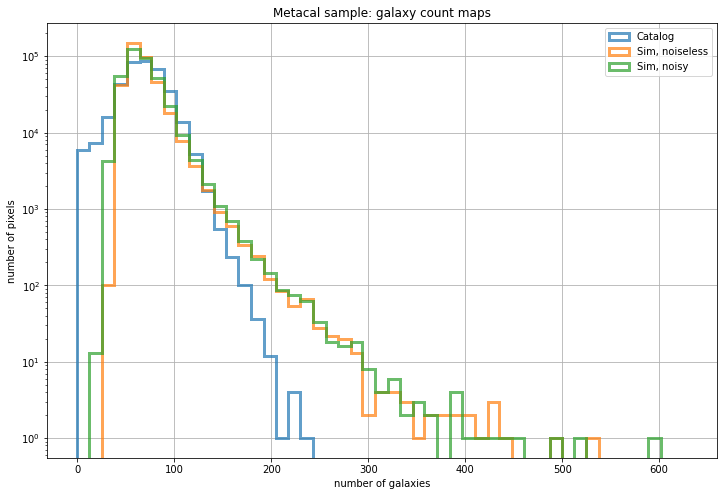

In [81]:
count_maps = [
    metacal_counts,
    sim_counts,
    noisy_sim_counts,
]

labels = [
    "Catalog",
    "Sim, noiseless",
    "Sim, noisy",
]

fig_cls, ax_cls = plt.subplots(figsize=(12,8))

fig_hist, ax_hist = plt.subplots(figsize=(12,8))
stacked_maps = np.stack(count_maps)
bins = np.linspace(stacked_maps.min(), stacked_maps.max(), 50, dtype=int)

for count_map, label in zip(count_maps, labels):    
    # consider the same patch for all
    count_map[anti_patch_pix] = 0

    cls = hp.anafast(count_map, use_pixel_weights=True)
    ax_cls.loglog(cls, label=label)

    ax_hist.hist(count_map[patch_pix], bins=bins, label=label, alpha=0.7, histtype="step", linewidth=3, log=True)

ax_cls.legend()
ax_cls.set(xlabel="l", ylabel="Cl", title="Metacal sample: galaxy count maps")
ax_cls.grid(True)

ax_hist.legend()
ax_hist.set(xlabel="number of galaxies", ylabel="number of pixels", title="Metacal sample: galaxy count maps")
ax_hist.grid(True)